# Multi Agent System

This notebook demonstrates how to build a multi-agent financial research and analysis system with RAG, web search, and code generation.

## Key Components

1. **Setup and Configuration**
   - Installation of required packages (langchain-community, langchain-openai, chromadb, e2b)
   - Configuration of API keys (OpenAI, Tavily, E2B, Langchain/Langsmith)
   - Import of necessary libraries and components

2. **Build RAG Index**
   - Building a vector index from PDF documents
   - Setting up document retrieval and embedding systems
   - Implementation of document splitting and processing

3. **Intelligent Routing**
   - Question router for directing queries to appropriate data sources (RAG for internal documents, web search for external information)
   - Retrieval grader for assessing document relevance
   - Hallucination detection and answer validation (and routing to web search as a fallback)

4. **Code Interpretation and Visualization**
   - Python code interpreter integration to generate output financial analysis visualizations in a sandboxed environment
   - Graph state management and workflow definition
   - Visualization tools for data representation

5. **Graph-Based Workflow**
   - Implementation of state-based graph workflow
   - Integration of web search and vector store retrieval
   - Conditional routing based on document source (RAG or web search) and answer relevance (hallucination detection and answer grading)

6. **Interface**
   - Test the system
   - Visual graph representation using IPython display
   - Gradio-based interactive interface

This notebook provides a comprehensive example of building a multi-agent system that can handle financial research and analysis tasks with quality controls for accuracy and reliability.

## Setup and Configuration

In [15]:
!pip install langchain-community==0.3.1
!pip install langchain-openai==0.2.0
!pip install chromadb==0.5.11
!pip install e2b==1.0.2
!pip install e2b-code-interpreter==1.0.1
!pip install langgraph==0.2.23
!pip install pypdf==5.1.0
!pip install -q gradio

In [3]:
import os
import getpass

In [4]:


# openai key
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAi Key here:")

# tavily key
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily Key here:")

# e2b key
os.environ["E2B_API_KEY"] = getpass.getpass("Enter your E2B Key here:")

Enter your OpenAi Key here:··········
Enter your Tavily Key here:··········
Enter your E2B Key here:··········


In [ ]:
# langchain key for langsmith tracing / observability
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your Langchain Key here:")

In [5]:
# from dotenv import load_dotenv
# load_dotenv()


## Build RAG Index

**Code Breakdown**

- **Imports Libraries**: The code imports several modules necessary for handling text processing and vector storage, including `pprint` for pretty-printing data and various components from the LangChain library.
  
- **Sets Up Embeddings**: It initializes the `OpenAIEmbeddings` class, which will be used to create vector representations of text for efficient retrieval.

- **Loads PDF Document**: The `PyPDFLoader` class is used to load internal PDFs into a document object for further processing.

- **Splits Text into Chunks**: The `RecursiveCharacterTextSplitter` is configured to split the loaded document into chunks of 500 characters, with no overlap, to facilitate better handling of the text for indexing.

- **Processes Document Splits**: The `split_documents` method is called to split the loaded document into manageable segments based on the defined chunk size.

- **Creates Vector Store**: The `Chroma` vector store is initialized with the split documents and the embeddings, creating an index for efficient searching and retrieval.

- **Configures Retriever**: Finally, the vector store is converted into a retriever, which will allow for querying the stored embeddings to retrieve relevant document chunks based on user input or queries.

In [16]:
from pprint import pprint
# RAG

### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = OpenAIEmbeddings()

# Load local document
local_doc_nvidia = PyPDFLoader("NVIDIA_Internal_Analysis.pdf").load() # change to your own path
local_doc_amd = PyPDFLoader("AMD_Internal_Analysis.pdf").load() # change to your own path

# Combine documents
local_docs = local_doc_nvidia + local_doc_amd
# Split
# Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
    # length_function=len,  # use character length
    # separators=["\n\n", "\n", " ", ""]  # default separators
)

doc_splits = text_splitter.split_documents(local_docs)

doc_splits = text_splitter.split_documents(local_docs)

# print this to see the splits
# for i, doc in enumerate(doc_splits, 1):
#     print(f"\nDocument Split #{i}:")
#     print("-" * 50)
#     print(doc.page_content)
#     print("-" * 50)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)

retriever = vectorstore.as_retriever()


## Intelligent Routing

### Create a Router

**Code Breakdown**

- **Imports Necessary Modules**: The code imports required classes and functions for creating prompts, managing OpenAI models, and defining data models.

- **Defines Data Model**: The `RouteQuery` class uses Pydantic to define a model that represents a routing decision, specifying whether to use a vector store or web search based on the user query.

- **Initializes Language Model**: An instance of `ChatOpenAI` is created with the GPT-4o model.

- **Sets Up Structured Output**: The `structured_llm_router` is prepared to output results as instances of the `RouteQuery` model, allowing for clear routing decisions.

- **Creates System Prompt**: A prompt is defined that instructs the language model to route queries specifically related to financial statements of "NVIDIA" and "AMD" to the vector store, while routing other company inquiries to web search.

- **Builds Prompt Template**: The `ChatPromptTemplate` is created from the system and user message templates, facilitating structured conversation with the model.

- **Combines Prompt and Router**: The prompt and the structured output router are combined into a `question_router`, which will handle user inquiries.

- **Invokes Question Router**: Two example queries are processed through the `question_router`. The first query about NVIDIA is routed to the vector store, while the second query about Intel is directed to web search, with results printed for each.

In [17]:

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to financial statements of the companies "NVIDIA" and "AMD".
Use the vectorstore for questions on financial statements of these companies. For questions on other Companies, use web-search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

# test the router for a question about internal documents
print(
    question_router.invoke(
        {"question": "What is the trend for qualterly revenue for NVIDIA in the last year"}
    )
)
# test the router for a question about external information
print(question_router.invoke({"question": "What is the trend for qualterly revenue for Intel in the last year"}))

datasource='vectorstore'
datasource='web_search'


### Retrieval Grader

**Code Breakdown**

- **Defines Grading Model**: The `GradeDocuments` class uses Pydantic to create a model for grading the relevance of retrieved documents, with a binary score indicating relevance as "yes" or "no."

- **Initializes Language Model**: A `ChatOpenAI` instance is created with the GPT-4o model.

- **Sets Up Structured Output**: The `structured_llm_grader` is prepared to provide structured outputs based on the `GradeDocuments` model, enabling clear grading decisions.

- **Creates Grading Prompt**: A system prompt is defined to instruct the model on how to assess the relevance of a retrieved document, emphasizing the identification of keywords or semantic relevance without strict criteria.

- **Builds Prompt Template**: The `ChatPromptTemplate` is constructed to format the input from both the system and user, incorporating the retrieved document and user question for the grading task.

- **Combines Prompt and Grader**: The `grade_prompt` is combined with the structured output to create the `retrieval_grader`, which will evaluate the relevance of documents based on user questions.

- **Retrieves Documents**: The `retriever` is used to fetch relevant documents based on a specific question regarding NVIDIA's Fiscal Year Revenue.

- **Grades Retrieved Document**: The code extracts the content of a specific document and invokes the `retrieval_grader` to assess its relevance to the question, printing the binary relevance score ("yes" or "no") as the output.

In [18]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "What is the Fiscal Year Revenue for NVIDIA in the last year"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Generate a response

**Code Breakdown**

- **Imports Required Modules**: The code imports necessary modules from LangChain, including functionality to pull prompts from the hub and output parsers.

- **Pulls Prompt from Hub**: A prompt is retrieved from the LangChain hub using `hub.pull`, allowing for a pre-defined structure to guide the model's responses.

- **Initializes Language Model**: An instance of `ChatOpenAI` is created with the GPT-4o model.

- **Defines Document Formatting Function**: A `format_docs` function is defined to concatenate the contents of retrieved documents into a single string, separated by new lines.

- **Creates Processing Chain**: A processing chain, `rag_chain`, is constructed by linking the pulled prompt, the language model, and an output parser (`StrOutputParser`) to handle the formatting of the final output.

- **Executes Chain with Input**: The `rag_chain` is invoked with a dictionary containing the context (retrieved documents) and the user question, generating a response based on the integrated components.

- **Prints Output**: The resulting generation is printed, displaying the model's answer informed by the context provided by the retrieved documents and the user question.

In [19]:

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The Fiscal Year Revenue for NVIDIA in the last year was $60.90 billion. This marked a significant increase of 126% from the previous year.


### Hallucination Grader

**Explanation of Code:**

1. **Defining a Data Model:** The `GradeHallucinations` class inherits from `BaseModel` and is designed to represent a binary score that will indicate whether an answer contains hallucination (non-factual information) or not. The `binary_score` field is a string that accepts two values: `'yes'` or `'no'`, based on whether the response is factually grounded.

2. **Configuring the LLM (Language Model):** An instance of `ChatOpenAI` named `llm` is created with the `gpt-4o` model.

3. **Structured Output for Grading:** The `structured_llm_grader` variable is created by wrapping the `llm` instance with the `with_structured_output` method, allowing the model to produce outputs based on the `GradeHallucinations` structure (i.e., returning only `'yes'` or `'no'` for factual accuracy).

4. **Defining the System Prompt:** A `system` message string is created to instruct the model that it should act as a grader, deciding whether an LLM-generated answer is grounded in or supported by provided facts.

5. **Prompt Template Creation:** `hallucination_prompt` is initialized as a `ChatPromptTemplate` using a `system` message and a `human` message template. The `human` message uses placeholders (`{documents}` and `{generation}`) for inserting the factual documents and the LLM’s generated response.

6. **Combining the Prompt and Grader:** `hallucination_grader` is created by combining `hallucination_prompt` with `structured_llm_grader`, ensuring that the structured output of the model will follow the specified grading format.

7. **Invocation of Grader:** The `invoke` method on `hallucination_grader` passes in the variables `docs` (factual references) and `generation` (the LLM's answer). The model assesses if `generation` aligns with `docs`, returning `'yes'` or `'no'` as a binary grade for factual grounding.

In [20]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### Answer Grader

**Explanation of Code:**

1. **Defining a Data Model:** The `GradeAnswer` class, which inherits from `BaseModel`, defines a data model to represent a binary score indicating if an answer sufficiently addresses a question. The field `binary_score` accepts a string value of `'yes'` or `'no'`.

2. **Setting Up the LLM (Language Model):** An instance of `ChatOpenAI` called `llm` is initialized using the model `gpt-4o`.

3. **Structured Output for Grading:** The `structured_llm_grader` variable wraps the `llm` instance with the `GradeAnswer` model using `with_structured_output`. This setup structures the output to only contain `'yes'` or `'no'`, based on whether the answer addresses the question.

4. **Creating a System Prompt:** The `system` string instructs the LLM to act as a grader, assessing if a given answer adequately addresses the question. It specifies a binary response format: `'yes'` if the answer resolves the question, and `'no'` otherwise.

5. **Prompt Template Definition:** `answer_prompt` is defined as a `ChatPromptTemplate` that includes a `system` message and a `human` message template. The `human` message includes placeholders (`{question}` and `{generation}`) for dynamically inserting the user’s question and the generated response.

6. **Combining the Prompt and Grader:** The `answer_grader` variable combines `answer_prompt` with `structured_llm_grader`, ensuring that the LLM produces structured binary output for grading purposes.

7. **Invoking the Grader:** The `invoke` method is used on `answer_grader` with inputs `question` (user’s question) and `generation` (the LLM’s response). The model evaluates if `generation` addresses `question`, returning a binary grade: `'yes'` or `'no'`.

In [21]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o")
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### Question Re-writer

**Explanation of Code:**

1. **Initializing the LLM (Language Model):** An instance of `ChatOpenAI` called `llm` is created using the model `gpt-4o`.

2. **System Prompt Definition:** The `system` string contains instructions for the LLM, designating it as a question re-writer. The re-writer’s role is to improve an input question so it’s optimized for retrieval from a vector store, focusing on the underlying semantic intent.

3. **Prompt Template Setup:** The `re_write_prompt` variable is initialized using `ChatPromptTemplate`. It combines a `system` message to define the LLM’s role and a `human` message template, which includes a placeholder (`{question}`) for dynamically inserting the initial question to be rephrased.

4. **Combining Prompt with LLM:** The `question_rewriter` variable is created by chaining `re_write_prompt` with `llm` and `StrOutputParser()`. This setup means the output will be a direct string containing the rephrased question.

5. **Invoking the Question Re-writer:** The `invoke` method is used on `question_rewriter`, passing in `question` (the initial user question) as input. The model processes the question and returns an improved version that’s optimized for semantic retrieval.

In [22]:


# LLM
llm = ChatOpenAI(model="gpt-4o")

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"What was NVIDIA's revenue in the most recent fiscal year?"

### Search Tool

**Explanation of Code:**

1. **Importing the TavilySearchResults Tool:** The `TavilySearchResults` class is imported from `langchain_community.tools.tavily_search`. This class provides a tool for performing web searches and retrieving search results.

2. **Initializing the Web Search Tool:** An instance of `TavilySearchResults` called `web_search_tool` is created with the parameter `k=3`. This parameter specifies that only the top 3 search results should be retrieved in response to each search query.

3. **Purpose of the Web Search Tool:** The `web_search_tool` enables integration of real-time web search functionality, allowing the system to access and retrieve relevant online information dynamically when needed.

In [23]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Python Code interpreter

**Explanation of Code:**

1. **Imports and Environment Setup:** The code imports necessary modules for handling Python code execution (`os`, `json`, `Any`, `BaseModel`, and `Field`). It imports `CodeInterpreter` to manage Python code interpretation within a sandboxed environment, and other components like `ToolMessage` for managing messages and tool communication.

2. **Defining Message Classes:** `RichToolMessage`, inheriting from `ToolMessage`, defines a structure for messages returned from the tool, including raw execution output in a dictionary format.

3. **Data Model for Code Execution:** The `LangchainCodeInterpreterToolInput` class defines the input data model for Python code to execute. It has a single `code` field that describes the code string to be interpreted.

4. **Defining Code Interpreter Tool:** `CodeInterpreterFunctionTool` is a class that sets up a Python code interpreter tool with a `tool_name` attribute and manages the E2B sandboxed interpreter. If the `E2B_API_KEY` is missing in the environment, it raises an exception, ensuring secure API access.

5. **Code Execution and Handling:** The `call` method retrieves the code from parameters, executes it in a notebook cell, and returns a dictionary with execution results, `stdout`, `stderr`, and any errors encountered. The `langchain_call` method simplifies calling `call` by passing only a code string.

6. **Tool Conversion to Langchain:** The `to_langchain_tool` method integrates the interpreter into Langchain as a `Tool`, allowing it to handle code execution and return output. `Tool` is configured to accept only Python code as input and provide results as rich data.

7. **Output Formatting for Messages:** The `format_to_tool_message` static method processes the output of the code interpreter, transforming it into a structured `RichToolMessage` format, ready for the Langchain system to consume.

8. **LLM Initialization and Workflow Setup:** The `ChatOpenAI` model is initialized as `llm` with `gpt-4o`. This model is incorporated into a `MessageGraph` workflow, which manages LLM-tool interactions.

9. **Defining Workflow Logic:** `should_continue` checks if a function call exists in the last message. If not, it signals the end (`END`). Otherwise, it proceeds with tool execution.

10. **Tool Execution Logic:** `execute_tools` runs tools based on `tool_calls` in the last message, invokes the appropriate tool, and appends the results as `RichToolMessage`s for further handling.

11. **Workflow Graph Definition:** The workflow graph has nodes (`agent`, `action`) with conditional edges based on `should_continue`, creating a loop until `should_continue` signals `END`. The workflow compiles into `interpreter_app`, which orchestrates the execution and response handling.

12. **Executing the Workflow:** (Commented out in the code) The final step would involve invoking the `interpreter_app` with a user command, such as `"plot and show sinus"`, triggering the workflow to interpret and execute the code.

In [24]:
# Python Code interpreter

import os
import json

from typing import Any
import base64
from langchain_core.tools import Tool
from pydantic.v1 import BaseModel, Field
from e2b_code_interpreter import Sandbox
from langchain_core.messages import ToolMessage

class RichToolMessage(ToolMessage):
    raw_output: dict


class LangchainCodeInterpreterToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")


class CodeInterpreterFunctionTool:
    tool_name: str = "code_interpreter"

    def __init__(self):
        # Instantiate the E2B sandbox - this is a long lived object
        # that's pinging E2B cloud to keep the sandbox alive.
        if "E2B_API_KEY" not in os.environ:
            raise Exception(
                "Code Interpreter tool called while E2B_API_KEY environment variable is not set. Please get your E2B api key here https://e2b.dev/docs and set the E2B_API_KEY environment variable."
            )
        # self.code_interpreter = CodeInterpreter()
        self.sbx = Sandbox()

    # def close(self):
    #     # self.code_interpreter.close()
    #     self.sbx.close()

    def call(self, parameters: dict, **kwargs: Any):
        code = parameters.get("code", "")
        print(f"***Code Interpreting...\n{code}\n====")
        path_tracker.append(f"***Code Interpreting...\n{code}\n====")

        # try:
        #     execution = self.code_interpreter.notebook.exec_cell(code)
        # except Exception as e:
        #     # If execution fails, try reinitializing the interpreter
        #     self.close()
        #     self.code_interpreter = CodeInterpreter()
        #     execution = self.code_interpreter.notebook.exec_cell(code)

        # if self.code_interpreter:
        #     self.close()
        # self.code_interpreter = CodeInterpreter()
        # execution = self.code_interpreter.notebook.exec_cell(code)

        # if self.sbx:
        #     self.close()
        self.sbx = Sandbox()
        execution = self.sbx.run_code(code)

        # content = self.sbx.files.read("output_graph.png")
        # print(content)
        # with open("output_graph.png", "wb") as f:
        #     f.write(content)

        first_result = execution.results[0]
        if first_result.png:
            with open("output_graph.png", "wb") as f:
                f.write(base64.b64decode(first_result.png))
        return {
            "results": execution.results,
            "stdout": execution.logs.stdout,
            "stderr": execution.logs.stderr,
            "error": execution.error,
        }

    # langchain does not return a dict as a parameter, only a code string
    def langchain_call(self, code: str):
        return self.call({"code": code})

    def to_langchain_tool(self) -> Tool:
        tool = Tool(
            name=self.tool_name,
            description="Execute python code in a Jupyter notebook cell and returns any rich data (eg charts), stdout, stderr, and error.",
            func=self.langchain_call,
        )
        tool.args_schema = LangchainCodeInterpreterToolInput
        return tool

    @staticmethod
    def format_to_tool_message(
        tool_call_id: str,
        output: dict,
    ) -> RichToolMessage:
        """
        Format the output of the CodeInterpreter tool to be returned as a RichToolMessage.
        """

        # TODO: Add info about the results for the LLM
        content = json.dumps(
            {k: v for k, v in output.items() if k not in ("results")}, indent=2
        )

        return RichToolMessage(
            content=content,
            raw_output=output,
            tool_call_id=tool_call_id,
        )

from typing import List
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessageGraph


# Define the function that determines whether to continue or not
def should_continue(messages) -> str:
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    else:
        return "action"


# Handle tools execution
def execute_tools(messages, tool_map) -> List[RichToolMessage]:
    tool_messages = []
    for tool_call in messages[-1].tool_calls:
        tool = tool_map[tool_call["name"]]
        if tool_call["name"] == CodeInterpreterFunctionTool.tool_name:
            output = tool.invoke(tool_call["args"])
            message = CodeInterpreterFunctionTool.format_to_tool_message(
                tool_call["id"],
                output,
            )
            tool_messages.append(message)
        else:
            content = tool.invoke(tool_call["args"])
            tool_messages.append(RichToolMessage(content, tool_call_id=tool_call["id"]))
    return tool_messages

# 1. Initialize the LLM
llm = ChatOpenAI(model="gpt-4o")

# 2. Initialize the code interpreter tool
code_interpreter = CodeInterpreterFunctionTool()
code_interpreter_tool = code_interpreter.to_langchain_tool()
tools = [code_interpreter_tool]
tool_map = {tool.name: tool for tool in tools}

# 3. Define the graph
workflow = MessageGraph()
workflow.add_node("agent", llm.bind_tools(tools))
workflow.add_node("action", lambda x: execute_tools(x, tool_map))

# Conditional agent -> action OR agent -> END
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
# Always transition `action` -> `agent`
workflow.add_edge("action", "agent")

workflow.set_entry_point("agent")

interpreter_app = workflow.compile()

# # 4. Invoke the app
# result = interpreter_app.invoke([("human", "plot and show sinus")])




## Define the Graph

### Graph State

**Explanation of Code:**

1. **Importing Required Types:** The code imports `List` from Python’s `typing` module and `TypedDict` from `typing_extensions`. `TypedDict` is used to create a dictionary-like data structure with specific key-value pairs and type annotations.

2. **Defining `GraphState` Class:** `GraphState` is a subclass of `TypedDict`, designed to represent the state of a graph during processing. Each attribute in `GraphState` has an explicitly defined type.

3. **Attributes of `GraphState`:**
   - **`question`:** A string representing the user’s question that the system is working with.
   - **`generation`:** A string holding the generated answer or output from the language model (LLM).
   - **`documents`:** A list of strings, where each element represents a document related to the `question` or `generation`.
   - **`last_used_tool`:** A string that stores the name of the last tool used, which could be `'search'` or `'vectorstore'`.

4. **Purpose of `GraphState`:** This class provides a structured way to manage and track essential elements of the graph’s state, making it easier to access and manipulate information during processing and debugging.

In [25]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        last_used_tool: search or vectorstore
    """

    question: str
    generation: str
    documents: List[str]
    last_used_tool: str

In [26]:
def return_no_first_time(input_value):
    """
    Returns 'no' on first call and returns input value on subsequent calls.

    Args:
        input_value: Any input value

    Returns:
        str: 'no' on first call, input_value afterwards
    """
    if not hasattr(return_no_first_time, 'called'):
        return_no_first_time.called = True
        return "no"
    return input_value

### Graph Functions

**Explanation of Code:**

1. **`display_results`:** This function displays the results from an interpreter's output by iterating through each `message` in `result` and displaying the content if `raw_output["results"]` is present.

2. **`create_graph`:** This function generates graphs based on the `generation` data from `state`. It sends a plotting command to `interpreter_app`, closes the code interpreter, and displays the results.

3. **`redirect_to_last_used_tool`:** Redirects to the last tool used (`search` or `vectorstore`) based on the `last_used_tool` value in `state`.

4. **`retrieve`:** Retrieves documents relevant to the `question` in `state` using a retriever, updating `state` with retrieved documents and setting `last_used_tool` to `"vectorstore"`.

5. **`generate`:** Generates an answer using retrieved documents by invoking a Retrieval-Augmented Generation (RAG) chain, which combines retrieved context with `question` to create a relevant response.

6. **`grade_documents`:** Filters documents based on relevance to `question`. It invokes `retrieval_grader` for each document, keeping only those graded as relevant.

7. **`reroute_question`:** Acts as a placeholder function to potentially modify the question routing without changing `state`.

8. **`transform_query`:** Improves the original `question` for better retrieval performance using `question_rewriter`, updating `state` with the new query.

9. **`web_search`:** Executes a web search with the improved `question` and appends results as a `Document` object to `state`.

### Edge Functions

10. **`route_question`:** Routes `question` to either `web_search` or `vectorstore` based on `question_router`'s analysis of the question’s context.

11. **`decide_to_generate`:** Decides whether to proceed with answer generation or reformulate the question. If relevant documents are available, it returns `"generate"`; otherwise, it triggers `"transform_query"`.

12. **`grade_generation_v_documents_and_question`:** Validates if the generated answer is grounded in the documents and answers the question. It uses `hallucination_grader` to detect any hallucination in the answer. If the answer is grounded and relevant to the question, the function returns `"useful"`, otherwise it returns `"not useful"` or `"not supported"`.

In [27]:
from langchain.schema import Document

def display_results(result):
    for message in result:
        if hasattr(message, 'raw_output'):
            if message.raw_output["results"]:
                rs = message.raw_output["results"]
                for r in rs:
                    display(r)


def create_graph(state):
    generation = state["generation"]
    print("---GENERATE GRAPHS---")
    print(generation)
    path_tracker.append(f"***GENERATE GRAPHS...\n{generation}\n====")

    result = interpreter_app.invoke([("human", "Plot the following data: \n\n" + generation)])
    # code_interpreter.close()
    display_results(result)
    print("---GRAPHS GENERATED---")
    path_tracker.append("---GRAPHS GENERATED---")
    return {"generation": "graphs generated"}


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    path_tracker.append("---RETRIEVE---")

    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "last_used_tool": "vectorstore"}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    path_tracker.append("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    path_tracker.append("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            path_tracker.append("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            path_tracker.append("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def reroute_question(state):
    print("---REROUTE QUESTION---")
    path_tracker.append("---REROUTE QUESTION---")
    last_used_tool = state["last_used_tool"]
    print("last used tool: ", last_used_tool)
    print("now redirecting to: ", "web_search")
    path_tracker.append("last used tool: ", last_used_tool)
    path_tracker.append("now redirecting to: ", "web_search")
    return state


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    path_tracker.append("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    path_tracker.append("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question, "last_used_tool": "web_search"}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    path_tracker.append("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        path_tracker.append("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        path_tracker.append("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    path_tracker.append("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        path_tracker.append("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        path_tracker.append("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    path_tracker.append("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        path_tracker.append("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        path_tracker.append("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        # grade = return_no_first_time(score.binary_score)
        grade = score.binary_score
        print("Answer Grade =====>> ", grade)
        path_tracker.append(f"Answer Grade =====>> {grade}")
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            path_tracker.append("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            path_tracker.append("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        path_tracker.append("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Add Nodes and Edges to the Graph

**Explanation of Code:**

1. **Initializing StateGraph Workflow:**
   - `workflow` is an instance of `StateGraph` created with the `GraphState` state model to handle node states and transitions between nodes in a defined sequence.

2. **Adding Nodes to Workflow:**
   - Each function (`web_search`, `retrieve`, `grade_documents`, `generate`, etc.) is added as a node to the workflow. These nodes represent distinct tasks in the graph, such as performing a web search, generating a response, or grading document relevance.

3. **Building Graph with Conditional and Direct Edges:**
   - **`START` to Initial Routing:** Uses `route_question` to determine if the question should go to `web_search` or `retrieve` based on the question's nature. Conditional edges send it to `"web_search"` or `"retrieve"`.
   - **`web_search` to `generate`:** Direct edge linking `"web_search"` node to `"generate"`, implying generation will occur after web search.
   - **`retrieve` to `grade_documents`:** Direct edge from `"retrieve"` to `"grade_documents"` where retrieved documents are checked for relevance.

4. **Conditional Edges in Document Grading:**
   - **`grade_documents` to Next Step:** `decide_to_generate` determines if the system should rephrase the question (sending it to `transform_query`) or proceed with answer generation (sending it to `generate`).

5. **Transform Query and Retry:**
   - **`transform_query` to `retrieve`:** If the question is reformulated, it re-routes to `retrieve` to find relevant documents again.

6. **Generation and Quality Assessment:**
   - **`generate` to Further Steps:** `grade_generation_v_documents_and_question` assesses if the generated answer is grounded in documents and relevant.
   - It can re-route to:
     - `"generate"` if more refinement is needed.
     - `"create_graph"` if the generation is useful.
     - `"rerouter"` if the generation is not useful.

7. **Rerouting on Failure:**
   - **`rerouter` Re-Routes Based on Last Tool Used:** Depending on whether `"search"` or `"vectorstore"` was last used, `redirect_to_last_used_tool` sends it back to `"web_search"` or `"retrieve"`.

8. **Final Step and Graph Completion:**
   - **`create_graph` to `END`:** When a useful generation is produced and a graph is created, it directs to the `END`, completing the workflow.

9. **Compiling the Workflow:** `app = workflow.compile()` compiles the defined workflow, making it ready for execution.

In [28]:
from langgraph.graph import END, StateGraph, START

# Redefine the workflow with better organization
workflow = StateGraph(GraphState)

# 1. Add all nodes first
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("create_graph", create_graph)
workflow.add_node("rerouter", reroute_question)

# 2. Define edges in a more structured way
# Initial routing
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)

# Vector store path
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")

# Web search path
workflow.add_edge("web_search", "generate")

# Generation evaluation and results
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Loop back for regeneration
        "useful": "create_graph",     # Proceed to visualization
        "not useful": "rerouter",     # Try alternative approach
    },
)

# Final paths
workflow.add_edge("rerouter", "web_search")
workflow.add_edge("create_graph", END)

#Compile
app = workflow.compile()

## Interface

**Explanation of Code:**

1. **Define `inputs` with Question:**
   - `inputs` contains a single key-value pair where `"question"` is the input question, asking for the "Revenue of NVIDIA in the past 4 years".

2. **Stream Workflow Execution:**
   - `for output in app.stream(inputs)` iterates through the nodes in the `app` workflow, processing each node sequentially with the given `inputs`.

3. **Output Node Execution Details:**
   - For each `output` in the workflow, the code iterates over key-value pairs in the output dictionary, representing individual nodes.
   - `pprint(f"Node '{key}':")` prints the name of the current node being processed.
   - Optionally, all keys within each node's `value` dictionary can be printed by uncommenting the commented line. This would give a detailed view of the node's state, including document retrieval, grading, and generation.

4. **Print Final Generation Result:**
   - After the workflow completes, `pprint(value["generation"])` outputs the final generated response based on the question about NVIDIA's revenue. This final generation would contain a summary or specific information, depending on the retrieved and graded data.

In [29]:
def test_workflow(question):
    global path_tracker
    path_tracker = []
    # Run
    inputs = {
        "question": question
    }
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            print(f"Node '{key}':")
            path_tracker.append(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        print("\n---\n")
        path_tracker.append("\n---\n")
    # Final generation
    print(value["generation"])
    path_tracker.append(value["generation"])

    #load
    return "\n".join(path_tracker), "output_graph.png"  # The image is saved as output_graph.png in the create_graph function


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
Node 'retrieve':

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
Answer Grade =====>>  yes
---DECISION: GENERATION ADDRESSES QUESTION---
Node 'generate':

---

---GENERATE GRAPHS---
AMD's revenue in the past 4 years was as follows: 2019 - $6.73 billion, 2020 - $9.76 billion, 2021 - $16.43 billion, and 2022 - $23.60 billion. In 2023, AMD reported revenue of $22.68 billion, showing a slight decline from the previous year.
***Code Interpreting...
import matplotlib.pyplot as plt

years = [2019, 2020, 2021, 2022, 2023]
revenue = [6.73, 9.76, 16.43, 23.60, 22.68]

plt.figure(figsize=(10, 

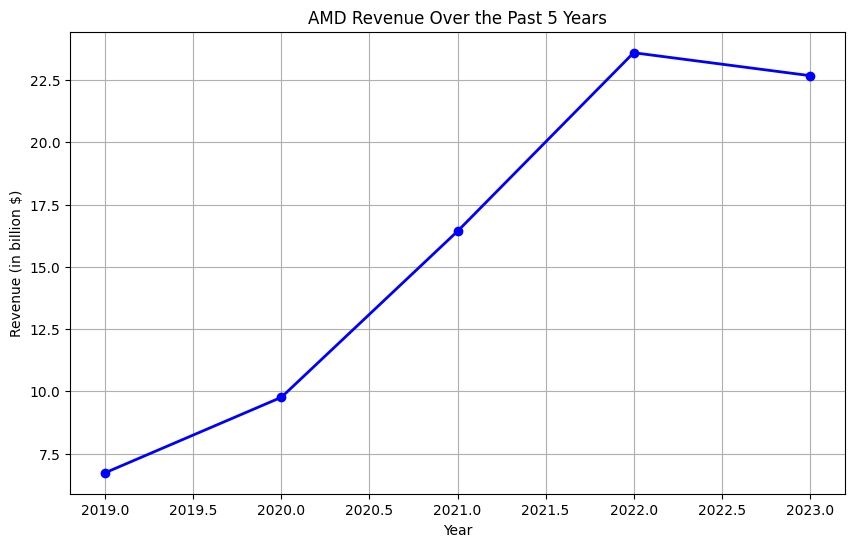

---GRAPHS GENERATED---
Node 'create_graph':

---

graphs generated


In [30]:
steps = test_workflow("Revenue of AMD in the past 4 years")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
Node 'retrieve':

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
Answer Grade =====>>  yes
---DECISION: GENERATION ADDRESSES QUESTION---
Node 'generate':

---

---GENERATE GRAPHS---
NVIDIA's revenue in the past four years has been as follows: $10.92 billion in 2020, $16.68 billion in 2021, $26.91 billion in 2022, and $26.97 billion in 2023. In fiscal year 2024, NVIDIA achieved a record revenue of $60.9 billion.
***Code Interpreting...
import matplotlib.pyplot as plt

years = [2020, 2021, 2022, 2023, 2024]
revenue = [10.92, 16.68, 26.91, 26.97, 60.9]

plt.figure(figsize=(10, 6))
plt.plot(yea

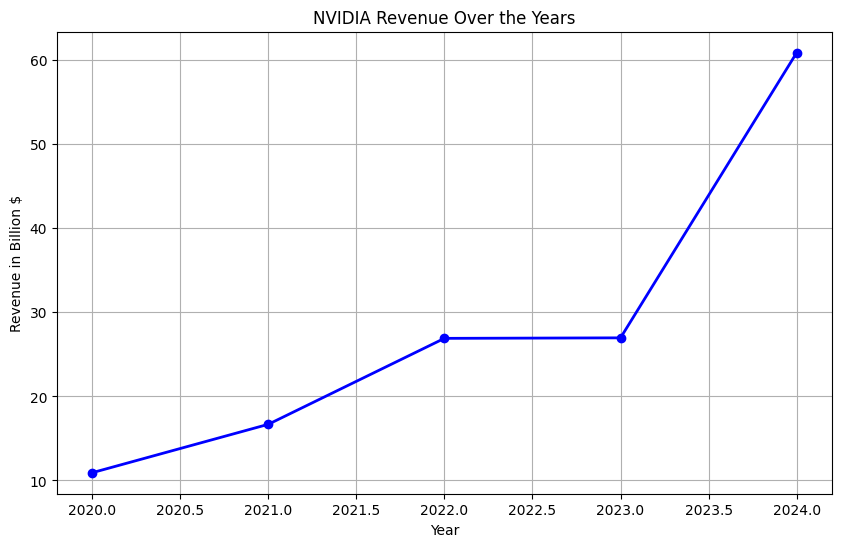

---GRAPHS GENERATED---
Node 'create_graph':

---

graphs generated


In [31]:
steps = test_workflow("Revenue of NVIDIA in the past 4 years")


### Visualize the Graph

Displaying the graph using ipython display.

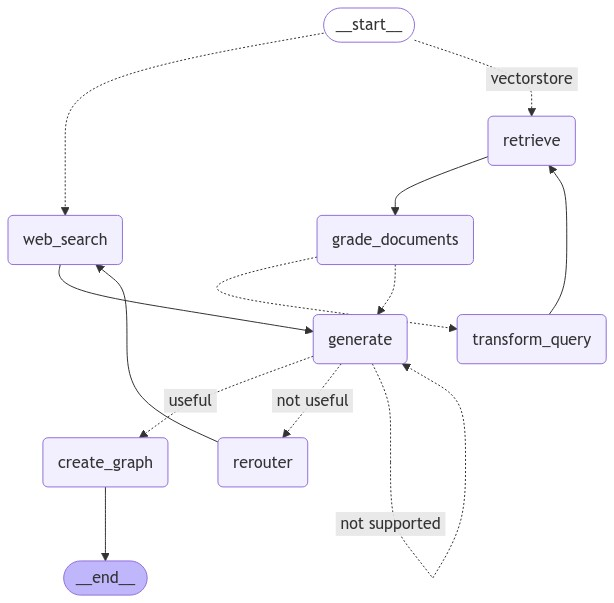

In [32]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

### Visual Interface

In [33]:
import gradio as gr

# Then update the Gradio interface
with gr.Blocks() as demo:
    prompt = gr.Textbox(label="Question")
    output = gr.Textbox(label="Steps")
    img_output = gr.Image(label="Generated Graph")
    ask_btn = gr.Button("Ask")
    ask_btn.click(
        fn=test_workflow,
        inputs=prompt,
        outputs=[output, img_output]
    )
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3e311b2982d4602f93.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
